## 문제 출처: https://github.com/DA4BAM/dataset


# 직원 이직 분석

* 최근 이직율이 증가하는 것에 대해 우려를 갖고 있기에, 이직여부에 영향을 주는 요인에 대해 분석하여, 직원들이 회사를 떠나지 않도록 인사 프로그램을 준비하려고 합니다.
* 필요하다면, 검색을 통해 '직원이 회사를 떠나는 이유' 등을 찾아보는 것은 데이터 분석을 하는데 도움이 될 것입니다.
* 이제 제공한 데이터를 바탕으로 각각 개별 변수의 분포를 살펴보며, 비즈니스 인사이트를 최대한 도출해 봅시다.

![](https://adoptostaging.blob.core.windows.net/media/employee-attrition-reasons-9LIqMv.jpg)

## 0.환경설정

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm

### 2) 데이터 로딩

In [2]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition_NA.CSV"
data = pd.read_csv(path)
data.drop(['EducationField', 'Education','JobInvolvement', 'StockOptionLevel', 'BusinessTravel','YearsWithCurrManager'
,'YearsInCurrentRole','JobRole', 'Department','EmployeeNumber','EnvironmentSatisfaction','TrainingTimesLastYear','YearsAtCompany']
          , axis = 1, inplace = True)
data['Attrition'] = np.where(data['Attrition']=='Yes', 1, 0)
data.head(10)

,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance
0,0,33,7.0,Male,3,Married,11691,0.0,No,11,4,14,4
1,0,35,18.0,Male,4,Single,9362,2.0,No,11,3,10,3
2,0,42,6.0,Male,1,Married,13348,9.0,No,13,2,18,4
3,0,46,2.0,Female,1,Married,17048,8.0,No,23,1,28,3
4,0,39,NaN,Male,4,Divorced,4127,2.0,No,18,4,7,3
5,1,22,4.0,Male,3,Single,3894,5.0,No,16,3,4,3
6,0,24,21.0,Male,1,Divorced,2296,0.0,No,14,2,2,3
7,0,34,8.0,Male,3,Married,4404,2.0,No,12,1,6,4
8,0,30,20.0,Male,1,Married,9957,0.0,No,15,3,7,2
9,0,26,6.0,Female,4,Married,2659,1.0,Yes,13,3,3,3


|	구분	|	변수 명	|	내용	|	type	|	비고	|
|	----	|	----	|	----	|	----	|	----	|
|	**Target**	|	**Attrition**	|	이직여부, Yes , No	|	범주	| 1- 이직, 0- 잔류		|
|	feature	|	Age	|	나이	|	숫자	|		|
|	feature	|	DistanceFromHome	|	집-직장 거리	|	숫자	|	마일	|
|	feature	|	Gender	|	성별	|	범주	| Male, Female		|
|	feature	|	JobSatisfaction	|	직무 만족도	|	범주	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	feature	|	MaritalStatus	|	결혼상태	|	범주	| Single, Married, Divorced		|
|	feature	|	MonthlyIncome	|	월급	|	숫자	| 달러	|
|	feature	|	NumCompaniesWorked	|	입사 전 근무한 회사 수	|	숫자	|	0 - 우리회사가 첫 직장	|
|	feature	|	RelationshipSatisfaction	|	동료와의 관계	|	범주	| 1 Low, 2 Medium, 3 High, 4 Very High		|
|	feature	|	OverTime	|	야근여부	|	범주	|	Yes, No	|
|	feature	|	PercentSalaryHike	|	전년대비 급여인상율	|	숫자	|	%	|
|	feature	|	TotalWorkingYears	|	총 경력 연수	|	숫자	|		|
|	feature	|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	범주	|	1 Bad, 2 Good, 3 Better, 4 Best	|

----

## 1.가설수립

* 각 변수는 직원의 이직여부와 관계가 있을 것이다.

----

## 2.단변량 분석

① 변수의 비즈니스 의미  

② 숫자? 범주?  

③ NaN 존재 여부 및 조치 방안  

④ 기초통계량  

⑤ 분포  

⑥ 위 정보로부터 파악한 내용(비즈니스!) 정리  

⑦ 추가 분석해볼 사항 도출

## 3.이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 유의수준 : 5%
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.
* (옵션)자료에 대한 가정 검정.(정규성, 등분산성 등)

In [3]:
target = 'Attrition'

### (1) 범주형 Feature --> Target
* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 교차표(pd.crosstab())  
    ② 시각화( Stacked Bar, Mosaic)  
    ③ 가설검정(카이제곱검정)
* 각 feature 별로 관계의 정도를 3가지로 정리해봅시다. 

#### 1) Gender --> Attrtion

In [4]:
feature = 'Gender'

① 교차표(pd.crosstab())

In [5]:
pd.crosstab(data[target], data[feature])

Gender,Female,Male
Attrition,,
0,421,629
1,69,131


② 시각화( Stacked Bar, Mosaic)

Gender       Female      Male
Attrition                    
0          0.400952  0.599048
1          0.345000  0.655000


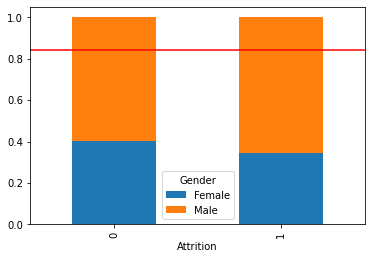

In [6]:
temp = pd.crosstab(data[target], data[feature], normalize = 'index')
print(temp)
temp.plot.bar(stacked=True)
plt.axhline(1 - data[target].mean(), color = 'r')
plt.show()

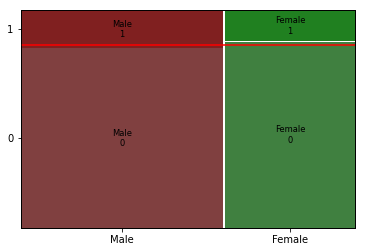

In [7]:
mosaic(data, [feature,target])
plt.axhline(1 - data[target].mean(), color = 'r')
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

남성이 여성보다 이직률이 높음을 알 수 있음.  
전체 직원의 성별을 비교해보면 남성 근무자가 더 많음을 알 수 있음.

③ 가설검정(카이제곱검정)

In [8]:
# 집계
table = pd.crosstab(data[target], data[feature])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 Gender     Female  Male
Attrition              
0             421   629
1              69   131
----------------------------------------------------------------------------------------------------
카이제곱통계량 1.9782495940105371
p-value 0.15957492990528155
기대빈도
 [[411.6 638.4]
 [ 78.4 121.6]]


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

- 시각화와 수치화로 보았을 때 성별에 따른 이직여부의 관계는 존재한다.  
    * 여성이 남성보다 이직률이 낮은 이유는 기업의 복지가 좋아서일 수 있음. EX육아휴직 등  
    * 반대로 남성의 이직률이 높은 것은 복지가 좋더라도 기대에 못 미치는 연봉때문일 수 있음.

#### 2) MaritalStatus --> Attrtion

In [9]:
feature = 'MaritalStatus'

① 교차표(pd.crosstab())

In [10]:
pd.crosstab(data[feature], data[target])

Attrition,0,1
MaritalStatus,,
Divorced,253,23
Married,501,69
Single,296,108


② 시각화( Stacked Bar, Mosaic)

Attrition             0         1
MaritalStatus                    
Divorced       0.916667  0.083333
Married        0.878947  0.121053
Single         0.732673  0.267327


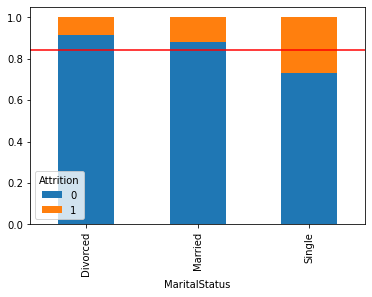

In [11]:
temp = pd.crosstab(data[feature], data[target], normalize = 'index')
print(temp)
temp.plot.bar(stacked = True)
plt.axhline(1 - data[target].mean(), color = 'r')
plt.show()

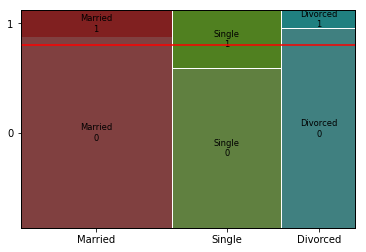

In [12]:
mosaic(data, [feature,target])
plt.axhline(1 - data[target].mean(), color = 'r')
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

- 결혼 상태에 따른 이직률의 차이가 존재함을 알 수 있음.  
    * 특히 미혼일수록 이직률이 높음을 알 수 있음.  
    * 반면 결혼하거나 이혼경력이 있는 이들의 경우 이직률의 비율이 다른 결혼 상태에 비해 상대적으로 낮음을 볼 수 있음.

③ 가설검정(카이제곱검정)

In [13]:
# 집계
table = pd.crosstab(data[feature], data[target])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 Attrition        0    1
MaritalStatus          
Divorced       253   23
Married        501   69
Single         296  108
----------------------------------------------------------------------------------------------------
카이제곱통계량 53.12935546374186
p-value 2.9047385436211595e-12
기대빈도
 [[231.84  44.16]
 [478.8   91.2 ]
 [339.36  64.64]]


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

- 시각화와 가설검정 모두 결혼상태에 따른 이직률에 관계가 있는 것을 확인할 수 있음.
    * 앞서 언급한 것처럼 결혼을 하거나 이혼 경력이 있는 이들의 비율이 미혼인 이들보다 상대적으로 이직률이 낮음을 볼 수 있는데, 이는 결혼한 상태로 더 안정적인 직장을 원하는 경향이 반영된 것으로 보임.  
    * 결혼한 이들과 이혼경력이 있는 이들의 이직 성향이 비슷하기 때문에 미혼인 이들의 이직의 대한 원인이 연봉에 있는 것인지, 아니면 개인으로서 받을 수 있는 회사 복지에 대한 문제인지 파악할 필요가 있음.

#### 3) JobSatisfaction --> Attrtion

In [14]:
feature = 'JobSatisfaction'

① 교차표(pd.crosstab())

In [15]:
pd.crosstab(data[feature], data[target])

Attrition,0,1
JobSatisfaction,,
1,197,53
2,196,39
3,308,60
4,349,48


② 시각화( Stacked Bar, Mosaic)

Attrition               0         1
JobSatisfaction                    
1                0.788000  0.212000
2                0.834043  0.165957
3                0.836957  0.163043
4                0.879093  0.120907


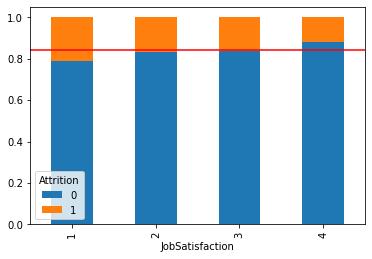

In [16]:
temp = pd.crosstab(data[feature], data[target], normalize = 'index')
print(temp)
temp.plot.bar(stacked=True)
plt.axhline(1 - data[target].mean(), color = 'r')
plt.show()

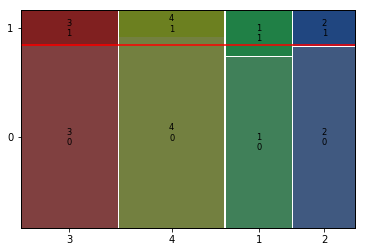

In [17]:
mosaic(data, [feature,target])
plt.axhline(1 - data[target].mean(), color = 'r')
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

- 직업 만족도에 따라 이직률의 차이가 있음을 확인할 수 있음.
    * 직업 만족도가 제일 낮은 1의 경우 이직률의 비율이 다른 만족도보다 높음.  
    * 직업 만족도가 제일 높은 4의 경우 이직률의 비율이 다른 만족도보다 낮음.
    * 전체 만족도의 비율을 확인했을 때 업무 만족도가 높은(3, 4)의 비율이 약 과반을 넘음.
    * 그러나 전체 만족도의 비율 중 만족도가 낮은(1, 2)의 비율도 적지 않음.

③ 가설검정(카이제곱검정)

In [18]:
# 집계
table = pd.crosstab(data[feature], data[target])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 Attrition          0   1
JobSatisfaction         
1                197  53
2                196  39
3                308  60
4                349  48
----------------------------------------------------------------------------------------------------
카이제곱통계량 9.63151465436614
p-value 0.021972649369306214
기대빈도
 [[210.    40.  ]
 [197.4   37.6 ]
 [309.12  58.88]
 [333.48  63.52]]


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

- 직업만족도에 따른 이직률의 차이가 있음을 확인할 수 있음.
    * 전체 만족도를 높은편(3, 4), 낮은편(1, 2)로 보았을 때 둘의 비율이 크게 차이 나지 않음.
    * 따라서 업무 만족도를 높이기 위한 방안이 필요해 보임.

### (2) 숫자형 Feature --> target

* 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 그래프 : histogram, densityplot   
    ② 수치화 : 로지스틱회귀

#### 1) Age --> Attrtion


In [19]:
feature = 'Age'

① 그래프 : histogram, densityplot

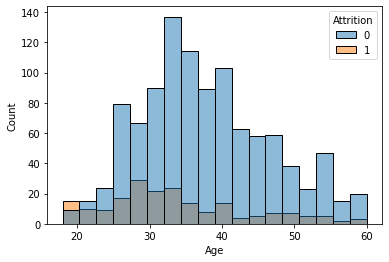

In [20]:
sns.histplot(x=feature, data = data, hue = target)
plt.show()

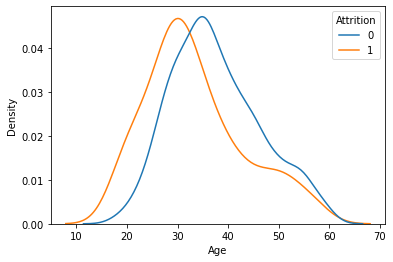

In [21]:
sns.kdeplot(x=feature, data = data, hue = target, common_norm = False)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

> 연령대에 따른 이직률의 관계가 보임  
    - 20대 중반부터 30대 중반까지의 이직률이 높게 분포해 있음을 알 수 있음.  
    - 40대 역시 전후 나이대보다 높은 이직률을 보임.  
    - 이후 높은 연령대에서의 이직률은 점차 감소함

② 수치화 : 로지스틱회귀

In [22]:
model = sm.Logit(data[target], data[feature])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.424660
         Iterations 5
Age    4.667821e-100
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

-  연령대에 따른 이직률의 관계가 존재함.  
    * 20대 중반부터 30대 중반의 연령대는 회사에서 실무를 담당하는 인재들임. 
    * 그런데 이들의 이직률이 고르고 높게 분포되어 있다는 것은 주변 회사에서 더 높은 연봉을 제시해 스카웃해가는 것이라 볼 수 있음. 
    * 또한 40대의 경우 회사의 중역을 맡는 관리자 급이기 때문에 타 회사에 역시 스카웃 제의가 올 확률이 높음.

#### 2) DistanceFromHome --> Attrtion


In [23]:
feature = 'DistanceFromHome'
temp = data.loc[data[feature].notnull()]

① 그래프 : histogram, densityplot

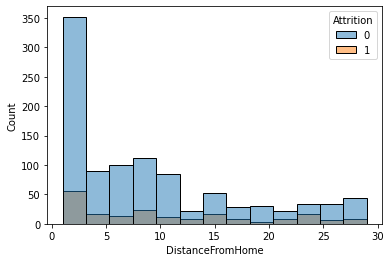

In [24]:
sns.histplot(x=feature, data = temp, hue = target)
plt.show()

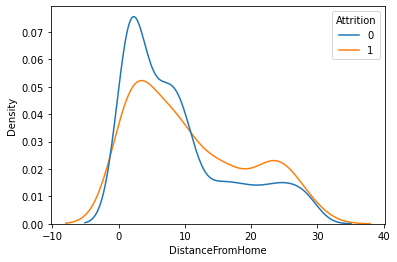

In [25]:
sns.kdeplot(x=feature, data = temp, hue = target, common_norm = False)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

- 거주지에서 직장으로부터의 거리가 짧을수록 이직률이 낮음을 알 수 있음.
    * 대체적으로 직장에서 거주지로부터의 거리가 15 이하에 많이 분포되어 있음
    - 그러나 15 ~ 25 처럼 점점 회사에서 거주지가 멀어질수록 이직하는 비율도 높아짐.
    - 이후 완전 멀리 있는 25 이후 부터는 이직률이 다시 감소함 (가족들과 사는 직원일 수 있음)

② 수치화 : 로지스틱회귀

In [26]:
temp = data.loc[data[feature].notnull()]
model = sm.Logit(temp[target], temp[feature])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.568793
         Iterations 6
DistanceFromHome    2.694280e-44
dtype: float64


#### ③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

- 거주지에서 직장으로부터의 거리가 짧을 수록 이직률이 낮음을 알 수 있음.
    * 전체 직원중 매우 가까이 살고 있는 직원들이 많기 때문에 회사에서 따로 제공하는 기숙사가 존재할 수도 있음. 
    * 그렇지 않은 이들의 경우 주로 이직률이 높은 15 ~ 20만큼의 거리에 있는 거주지에 지내고 있을 확률도 있음.  
    * 또한 많이 떨어진 곳에 살고 있는 이들의 이직률은 낮은데 이는 가족 구성원(자녀 학교 등) 때문에 그런 것일 수 있음.  

#### 3) MonthlyIncome --> Attrtion


In [27]:
feature = 'MonthlyIncome'

① 그래프 : histogram, densityplot

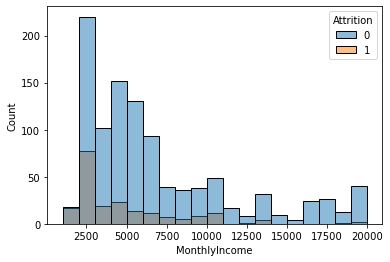

In [28]:
sns.histplot(x = feature, data = data, hue = target)
plt.show()

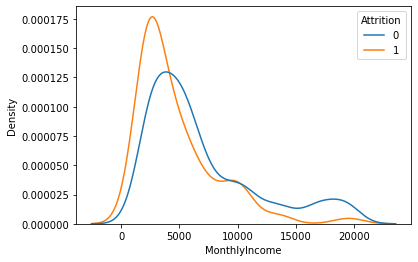

In [29]:
sns.kdeplot(x = feature, data = data, hue = target, common_norm = False)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

- 월별 소득이 낮은 (0 ~ 3000) 구간의 이직률이 매우 높음을 알 수 있음.  
    * 또한 5000~ 10000대 구간 역시 관리자 급들이 분포하고 있는 구간으로 추측 가능하며 경쟁사의 스카웃 제의가 들어올 가능성이 높음. 
    * 고액의 연봉을 받는 임원일수록 이직률이 기하급수적으로 낮아짐.

② 수치화 : 로지스틱회귀

In [30]:
model = sm.Logit(data[target], data[feature])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.437401
         Iterations 6
MonthlyIncome    1.922717e-71
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

- 이직률과 월급 간에는 관계가 존재한다.  
    * 월급이 매우 적은 구간이 보이는데, 혹시 회사 환경관리를 해주는 청소부분들의 연봉도 포함인건지 확인해 봐야함.
    * 신입부터 관리자급의 연봉(2500 ~ 7500)의 경우 해당 업무에 맡는 임금을 주고 있는지 경쟁사와 비교해 볼 필요가 있음.

> 

## 4.관계 정리

### 1) 강한관계의 변수

MaritalStatus, Age, DistanceFromHome, MonthlyIncome

### 2) 중간관계의 변수

Gender, JobSatisfaction 

### 3) (거의)관계 없음

-